In [41]:
import os

import matplotlib.pyplot as plt
import seaborn as sns
import torch

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

from shutil import copy2
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "trained_models/models_standard"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Eval model and baseline models

In [42]:
%rm -rf trained_models/models_standard/.DS_Store
%rm -rf trained_models/models_standard/piecewise_linear_vector_regression/.DS_Store
%rm -rf trained_models/models_standard/piecewise_linear_regression/.DS_Store
%rm -rf trained_models/models_tiny/.DS_Store
%rm -rf trained_models/models_tiny/piecewise_linear_vector_regression/.DS_Store
%rm -rf trained_models/models_tiny/piecewise_linear_vector_regression_multi_pivot/.DS_Store
%rm -rf trained_models/models_tiny/piecewise_linear_regression/.DS_Store
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
1,77d790d5-6a46-4380-8d11-f26af1071c2d,piecewise_linear_regression,Transformer,,-1,-1,1,12,8,piecewise_linear_regression
0,19b45183-0a15-4ba1-bc85-5efe7fb680bd,piecewise_linear_vector_regression,Transformer,,-1,-1,10,12,8,piecewise_linear_vector_regression


In [43]:
# ------------------------------------------------------------------
# Pick one global device; on your Mac this will be "cpu".
# ------------------------------------------------------------------
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"
print("Using device →", DEVICE)

Using device → cpu


In [44]:
task = "piecewise_linear_regression"
# task = "piecewise_linear_vector_regression"
# task = "sparse_linear_regression"
# task = "decision_tree"
# task = "relu_2nn_regression"

run_id = "77d790d5-6a46-4380-8d11-f26af1071c2d"  # if you train more models, replace with the run_id from the table above

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = True
skip_baselines = True

if recompute_metrics:
    get_run_metrics(run_path, skip_baselines = skip_baselines, DEVICE=DEVICE)  # these are normally precomputed at the end of training

  0%|          | 0/1 [00:00<?, ?it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


100%|██████████| 1/1 [01:07<00:00, 67.88s/it]


# Plot pre-computed metrics

In [45]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)
metrics['standard'].keys()

piecewise_linear_regression 77d790d5-6a46-4380-8d11-f26af1071c2d


100%|██████████| 1/1 [00:00<00:00, 4922.89it/s]


dict_keys(['Transformer'])

# The following code block is only for standard models, not tiny models.

piecewise_linear_regression 77d790d5-6a46-4380-8d11-f26af1071c2d


100%|██████████| 1/1 [00:00<00:00, 24385.49it/s]


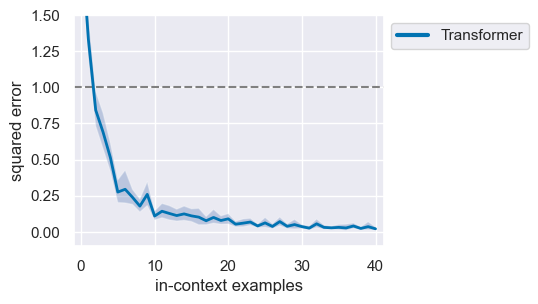

In [46]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task]
if skip_baselines:
    models = ["Transformer"]
basic_plot(metrics["standard"], models=models)
plt.show()

# Validation Loss

Evaluating step 100000… Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
MSE = 0.264887
Evaluating step 200000… Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
MSE = 0.265040
Evaluating step 300000… Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
MSE = 0.259866
Evaluating step 400000… Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processor

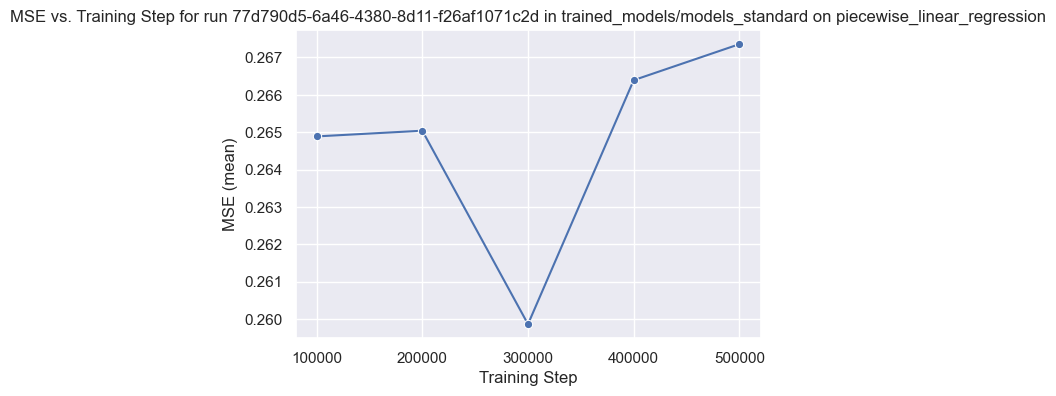

In [47]:
from shutil import copy2
import glob, os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from data_generation import get_data_sampler, get_task_sampler
import yaml

# ── 0) Paths & settings ──────────────────────────────────────────────
run_path     = os.path.join(run_dir, task, run_id)
orig_state   = os.path.join(run_path, "state.pt")
backup_state = orig_state + ".bak"
DEVICE       = DEVICE

# ── 1) Backup your original state.pt ─────────────────────────────────
if os.path.exists(orig_state):
    copy2(orig_state, backup_state)

# ── 2) Glob & sort your saved checkpoints ────────────────────────────
ckpt_paths = sorted(
    glob.glob(os.path.join(run_path, "model_*.pt")),
    key=lambda p: int(os.path.basename(p).split("_")[1].split(".pt")[0])
)

# ── 3) Load config.yaml so we know how to sample val set ──────────────
with open(os.path.join(run_path, "config.yaml")) as f:
    cfg = yaml.safe_load(f)

n_dims     = cfg["model"]["n_dims"]
bsize      = cfg["training"]["batch_size"]
task_name  = cfg["training"]["task"]
task_kwargs = cfg["training"].get("task_kwargs", {})

# ── 4) Build samplers and one fixed validation batch ────────────────
torch.manual_seed(282)
data_sampler = get_data_sampler(cfg["training"]["data"], n_dims=n_dims)
task_sampler = get_task_sampler(
    task_name,
    n_dims,
    bsize,
    num_tasks=cfg["training"].get("num_tasks"),
    **task_kwargs
)

xs_val = data_sampler.sample_xs(
    cfg["training"]["curriculum"]["points"]["end"],
    bsize,
    cfg["training"]["curriculum"]["dims"]["end"],
)
ys_val = task_sampler().evaluate(xs_val)
xs_val, ys_val = xs_val.to(DEVICE), ys_val.to(DEVICE)

# ── 5) Loop through each checkpoint, load it, compute MSE ─────────────
records = []
for ckpt in ckpt_paths:
    step = int(os.path.basename(ckpt).split("_")[1].split(".pt")[0])
    print(f"Evaluating step {step}…", end=" ")

    # load the model + conf for exactly that step
    model, conf = get_model_from_run(
        run_path,
        step=step,
        DEVICE=DEVICE
    )
    model.eval()

    # *** key change here: pass both xs_val and ys_val to forward ***
    with torch.no_grad():
        preds = model(xs_val, ys_val)
        mse   = ((preds - ys_val).square().mean().item())

    print(f"MSE = {mse:.6f}")
    records.append({"step": step, "mse": mse})

# ── 6) Restore your original state.pt ─────────────────────────────────
if os.path.exists(backup_state):
    copy2(backup_state, orig_state)

# ── 7) Make a DataFrame & plot ───────────────────────────────────────
df_ckpts = pd.DataFrame(records).sort_values("step")
print(df_ckpts)

plt.figure(figsize=(6, 4))
ax = sns.lineplot(data=df_ckpts, x="step", y="mse", marker="o")
ax.xaxis.set_major_locator(ticker.MultipleLocator(100_000))
plt.title(f"MSE vs. Training Step for run {run_id} in {run_dir} on {task}")
plt.xlabel("Training Step")
plt.ylabel("MSE (mean)")
plt.show()


# Plot Train/Val Loss Curve

In [ ]:
import wandb
import matplotlib.pyplot as plt

# 1) Initialize the API
api = wandb.Api()

# 2) Load your run by its full path: "<entity>/<project>/<run_id>"
#    e.g. "myusername/myproject/abcd1234"
run_path = "qianyu2025-university-of-california-berkeley/in-context-training/vald3twu" # standard piecewise scalar
# run_path = "qianyu2025-university-of-california-berkeley/in-context-training/9mcne8c0" # tiny piecewise scalar
run = api.run(f"{run_path}")  # e.g. "me/myproj/abc123"

CommError: Could not find run <Run qianyu2025-university-of-california-berkeley/in-context-training/77d790d5-6a46-4380-8d11-f26af1071c2d (not found)>

In [ ]:
# 3) Download the history for just the two loss keys
hist = run.history(keys=["overall_loss"])

# 4) Convert to Python lists
train_losses = hist["overall_loss"].tolist()


# 5) Plot
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.xlabel("Train Steps (k)")
plt.ylabel("MSE Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'run' is not defined

## Plot OOD metric

In [22]:
# plot any OOD metrics
for name, metric in metrics.items():
    if name == "standard": continue
   
    if "scale" in name:
        scale = float(name.split("=")[-1])**2
    else:
        scale = 1.0

    trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
    ax.set_title(name)
    
    if "ortho" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)

    plt.show()

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [20]:
from data_generation import get_data_sampler, get_task_sampler

In [21]:
model, conf = get_model_from_run(run_path,DEVICE=DEVICE)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [22]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)

In [23]:
with torch.no_grad():
    pred = model(xs, ys)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


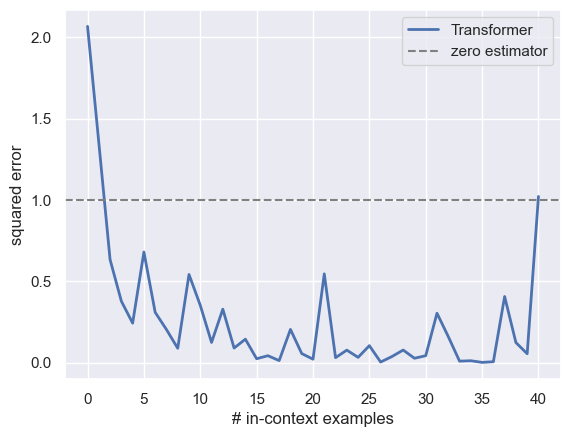

In [24]:
metric = task.get_metric()
loss = metric(pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "piecewise_linear_regression": 1,
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

As an exploration example, let's see how robust the model is to doubling all the inputs.

In [11]:
xs2 = 2 * xs
ys2 = task.evaluate(xs2)
with torch.no_grad():
    pred2 = model(xs2, ys2)

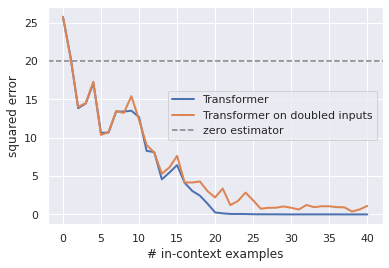

In [12]:
loss2 = metric(pred2, ys2).numpy()

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.plot(loss2.mean(axis=0) / 4, lw=2, label="Transformer on doubled inputs")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

The error does increase, especially when the number of in-context examples exceeds the dimension, but the model is still relatively accurate.